In [1]:
# 클러스터링 관련 참조
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression

from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 머신러닝 좌표계산
from scipy.spatial import ConvexHull

# Elbow Point 계산 라이브러리
from kneed import KneeLocator

#성능평가 지표
from hossam import visualize_silhouette

my_dpi = 200

c:\Users\wodyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.4.18

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.


In [2]:
origin = load_data('fish_processed')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전
데이터셋 크기: (56, 4)
열 개수: 4
행 개수: 56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


In [3]:
x = origin.drop('무게', axis= 1)
y = origin['무게']

estimator = LinearRegression(n_jobs = -1)

kf = KFold(n_splits = 5, shuffle = True, random_state = 52)

# 리터값이 음수를 적용함에 주의
cv_rmse = -cross_val_score(
    estimator, x, y, cv=kf, scoring ='neg_root_mean_squared_error'
)

cv_mean = cv_rmse.mean()
cv_std = cv_rmse.std()

print('CV RMSE 평균:', cv_mean)
print('CV RMSE 표준편차:', cv_std)

cv_ratio = cv_std / cv_mean
print('CV 변동성 비율:', cv_ratio)

if cv_ratio >= 0.20:
    print('과적합 가능성 높음: 교차검증 성능이 불안정함')
elif cv_ratio >= 0.10:
    print('과적합 의심: 교차검증 성능 변동이 있음')
else:
    print('일반화 안정: 교차검증 성능이 안정적임')
    

CV RMSE 평균: 0.24818139899860087
CV RMSE 표준편차: 0.14368675110521356
CV 변동성 비율: 0.578958583056515
과적합 가능성 높음: 교차검증 성능이 불안정함


### 1. 훈련/검증 데이터 분리

In [4]:
df = origin

yname = '무게'
x = df.drop(columns =[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 3), (14, 3), (42,), (14,))

### 2. 학습 모델 구축, RMSE 도출

In [5]:
estimator = LinearRegression(n_jobs = -1)
estimator.fit(x_train, y_train)
y_train_pred = estimator.predict(x_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train RMSE:', rmse_train)

Train RMSE: 0.2600199723387838


### 3. 교차검증 수행

In [6]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 52)

# cv 성능
cv_rmse = -cross_val_score(
    estimator, x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error'
)

cv_mean = cv_rmse.mean()
cv_std = cv_rmse.std()

print('CV RMSE 평균:', cv_mean)
print('CV RMSE 표준편차', cv_std)

CV RMSE 평균: 0.2949661770461281
CV RMSE 표준편차 0.15092874676512955


#### 4. 과적합 판정

In [7]:
cv_ratio = cv_std / cv_mean

# 기준값(수업용!!)
LARGE = 1.2 # '큼' 판단기준 (상대비교)
SMALL = 0.9 # '작음' 판단기준
STABLE = 0.10 # CV 안정
UNSTABLE = 0.20 # CV 불안정

# 상대비교
train_vs_cv = rmse_train / cv_mean

if train_vs_cv >= LARGE and cv_ratio <= STABLE:
    print('과소적합: 모델이 너무 단순')
elif train_vs_cv <= SMALL and cv_ratio >= UNSTABLE:
    print('과대적합: 일반화 실패')
elif train_vs_cv <= SMALL and cv_ratio <= STABLE:
    print('일반화 양호: 이상적')
elif train_vs_cv >= SMALL and cv_ratio > STABLE:
    print('데이터 부족 가능성: 표본 수 문제')
else:
    print('판단 유보: 추가 지표 필요')    

과대적합: 일반화 실패


#### 5. 학습 곡선 시각화 하기

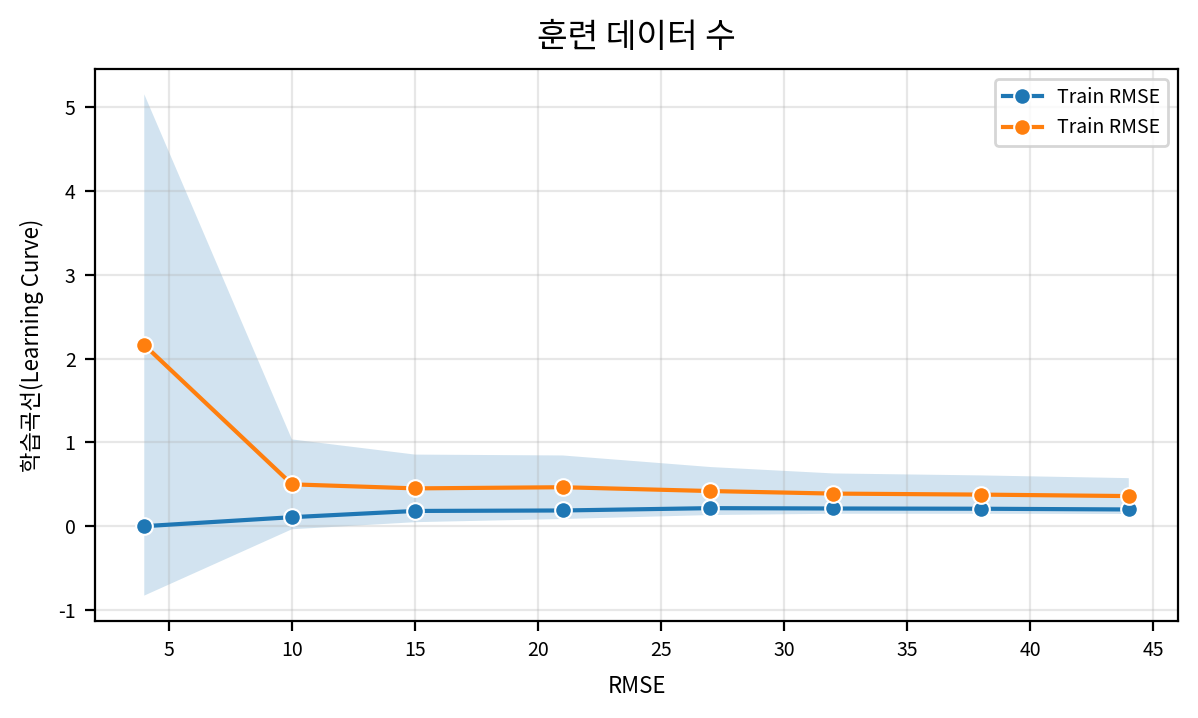

,지표,값
0,Train RMSE,0.199385
1,CV RMSE 평균,0.359186
2,CV RMSE 표준편차,0.213944
3,Train/CV 비율,0.555101
4,CV 변동성 비율,0.595635
5,판정 결과,과대적합: 일반화 실패


In [9]:
train_sizes, train_scores, cv_scores = learning_curve(
    estimator = estimator,
    X = x,
    y = y,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    train_sizes = np.linspace(0.1, 1.0, 8),
    shuffle = True,
    random_state = 52
)

# neg RMSE -> RMSE
train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균/표준편차
train_mean = train_rmse.mean(axis = 1)
cv_mean = cv_rmse.mean(axis = 1)
cv_std = cv_rmse.std(axis = 1)

# 마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train / final_cv
var_ratio = final_std / final_cv

if gap_ratio >= 1.2 and var_ratio <= 0.10:
    status = ('과소적합: 모델이 너무 단순')
elif gap_ratio <= 0.9 and var_ratio >= 0.20:
    status = ('과대적합: 일반화 실패')
elif gap_ratio <= 0.9 and var_ratio <= 0.20:
    status = ('일반화 양호')
elif gap_ratio <= 0.9 and var_ratio > 0.10:
    status = ('데이터 부족: 표본수 문제')
else:
    print('판단 유보: 추가 지표 필요')

# 시각화

figsize = (1200/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')
sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')

plt.fill_between(
    train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha = 0.2, label = 'CV +- 1 std'
)
ax.set_title('훈련 데이터 수', fontsize=12, pad= 8)
ax.set_xlabel('RMSE', fontsize=8, labelpad=5)
ax.set_ylabel('학습곡선(Learning Curve)', fontsize=8, labelpad=5)
ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()
plt.close()

# 정량 결과 표
result_df = DataFrame({
    '지표': [
        'Train RMSE',
        'CV RMSE 평균',
        'CV RMSE 표준편차',
        'Train/CV 비율',
        'CV 변동성 비율',
        '판정 결과'
    ],
    '값':[
        final_train,
        final_cv,
        final_std,
        gap_ratio,
        var_ratio,
        status,
    ]
})

result_df